# FMCW Radar with a Corner Reflector 

<a href="https://rookiepeng.github.io/radarsimpy/" target="_blank" rel="nofollow"><img src="https://img.shields.io/badge/Documentation-latest-brightgree?style=flat&logo=read-the-docs" height="20" align="left"></a>

<br></br>
This is an example of using [`RadarSimPy`](https://github.com/rookiepeng/radarsimpy) to simulate an FMCW radar with a corner reflector model (not an ideal point target).

---

## Setup FMCW radar

### Transmitter

Setup the basic transmitter parameters through `Transmitter` module.

The following table lists the parameters in this example.

 | Parameter                       | Variable in `Transmitter`| Value                      |
 |---------------------------------|--------------------------|----------------------------|
 | Frequency ($f$)                 | `f`                      | [77e9-50e6, 77e9+50e6] GHz |
 | Time ($T$)                      | `t`                      | 80e-6 s                    |
 | Transmitted power ($P_t$)       | `tx_power`               | 15 dBm                     |
 | Pulse repetition period ($PRP$) | `prp`                    | 100 us                     |
 | Number of pulses                | `pulses`                 | 256                        |

### Receiver

Setup the receiver parameters through `Receiver` module.

The parameters of the receiver are listed in the table below.

 | Parameter                        | Variable in `Receiver`   | Value        |
 |----------------------------------|--------------------------|--------------|
 | Sampling rate ($f_s$)            | `fs`                     | 2 Msps       |
 | Noise figure ($NF$)              | `noise_figure`           | 8 dB        |
 | RF gain/loss ($G_{rf}$)          | `rf_gain`                | 20 dB        |
 | Load resistor ($R_L$)            | `load_resistor`          | 500 $\Omega$ |
 | Baseband voltage gain ($G_{BB}$) | `baseband_gain`          | 30 dB        |


In [57]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver
wavelength = 3e8 / 77e9

tx_channel = dict(
    location=(0, 0, 0),
)

tx = Transmitter(f=[77e9-50e6, 77e9+50e6],
                 t=[0, 80e-6],
                 tx_power=15,
                 prp=100e-6,
                 pulses=256,
                 channels=[tx_channel])

channels = []
for idx in range(0, 32):
    channels.append(
        dict(
            location=(0, wavelength / 2 * idx, 0),
            # azimuth_angle=angle,
            # azimuth_pattern=pattern,
            # elevation_angle=angle,
            # elevation_pattern=pattern,
        ))

rx = Receiver(fs=2e6,
              noise_figure=8,
              rf_gain=20,
              load_resistor=500,
              baseband_gain=30,
              channels=channels)

radar = Radar(transmitter=tx, receiver=rx)


## Corner reflector model

The corner reflector model is with `.stl`. It can be imported by using `meshio` module. 

In [58]:
target_1 = {
    'model': '../models/cr.stl',
    'location': (50/np.sqrt(2), 50/np.sqrt(2), 0),
    'speed': (-5, 0, 0),
    'rotation': (45, 0, 0)
}

targets = [target_1]


Plot the 3D mesh of the corner reflector

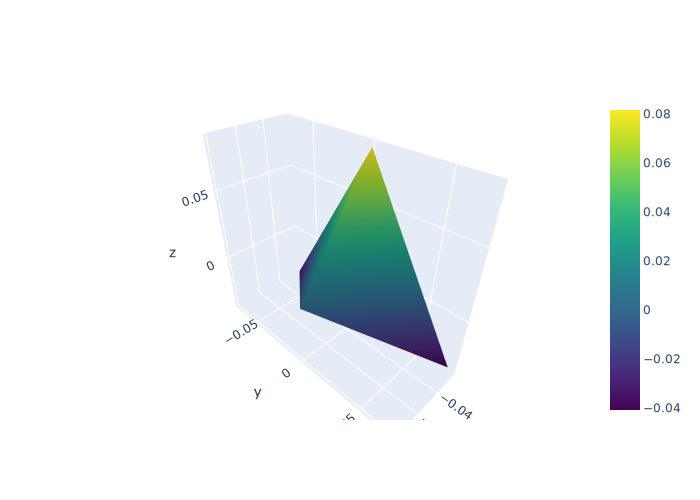

In [59]:
import meshio

import plotly.graph_objs as go
from IPython.display import SVG, display

mesh_data = meshio.read('../models/cr.stl')

fig = go.Figure()

fig.add_trace(go.Mesh3d(x=mesh_data.points[:, 0],
                        y=mesh_data.points[:, 1],
                        z=mesh_data.points[:, 2],
                        i=mesh_data.cells[0].data[:, 0],
                        j=mesh_data.cells[0].data[:, 1],
                        k=mesh_data.cells[0].data[:, 2],
                        intensity=mesh_data.points[:, 2],
                        colorscale='Viridis'
                        ))

# fig.show()
display(SVG(fig.to_image(format='svg', scale=1)))


## Raytracing

In [60]:
from radarsimpy.rt import scene
import time

tic = time.time()
data = scene(radar, targets, density=0.2, noise=True, debug=False)

baseband = data['baseband']
toc = time.time()

print('Exec time:', toc-tic, 's')


Exec time: 2.7201650142669678 s


In [61]:
np.shape(baseband)

(32, 256, 160)

## Radar signal processing

### Range processing

In [62]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.chebwin(radar.samples_per_pulse, at=60)
range_profile = proc.cal_range_profile(radar, baseband, range_window)


### Doppler processing

In [63]:
doppler_window = signal.chebwin(radar.transmitter.pulses, at=60)
range_doppler = proc.cal_range_doppler(
    radar, range_profile, doppler_window, fft_shift=False)


In [64]:
max_range = (3e8 * radar.receiver.fs *
             radar.transmitter.pulse_length /
             radar.transmitter.bandwidth / 2)
unambiguous_speed = 3e8 / radar.transmitter.prp[0] / \
    radar.transmitter.fc_vect[0] / 2

range_axis = np.linspace(
    0, max_range, radar.samples_per_pulse, endpoint=False)

doppler_axis = np.linspace(
    -unambiguous_speed, 0, radar.transmitter.pulses, endpoint=False)

fig = go.Figure()
fig.add_trace(go.Surface(x=range_axis, y=doppler_axis, z=20 *
              np.log10(np.abs(range_doppler[16, :, :])), colorscale='Rainbow'))

fig.update_layout(
    title='Range Doppler',
    height=600,
    scene=dict(
        xaxis=dict(title='Range (m)'),
        yaxis=dict(title='Velocity (m/s)'),
        zaxis=dict(title='Amplitude (dB)'),
    ),
    margin=dict(l=0, r=0, b=60, t=100),
    legend=dict(orientation='h'),
)

fig.show()
# display(SVG(fig.to_image(format='svg', scale=1)))


In [70]:
np.angle(range_doppler[:, 209, 33])/np.pi*180

array([ -66.98107193,  166.81320582,   30.38708253,  -94.17318247,
        138.75836419,   13.32939189, -117.38865132,  119.75382201,
         -2.44682291, -138.00467059,   90.25109146,  -29.42522329,
       -161.29686799,   68.83198016,  -55.79464517,  179.19851637,
         48.4816187 ,  -75.76152526,  148.79009649,   25.86947391,
       -101.65428339,  132.89444042,    8.84964234, -122.79094764,
        106.29590042,  -24.1057175 , -142.94755875,   87.68480833,
        -40.36248654, -170.91554635,   70.40321431,  -70.68961158])

In [73]:
np.abs(np.fft.fft(range_doppler[:, 209, 33]))

array([ 2.43717499,  2.6407723 ,  2.91304547,  0.92170753,  2.94194153,
        1.40590359,  3.56555964,  3.0073806 ,  2.45203852,  3.32291753,
        3.17748871,  3.1359148 ,  3.66065868,  3.92102926,  2.76097752,
        4.25451624,  5.55684586,  7.12555249,  8.27081194, 12.91426954,
       33.79588825, 65.01624697, 15.96037837,  9.29463926,  6.22927223,
        3.07654915,  3.84707023,  4.22995102,  2.78146262,  2.22878506,
        3.85369982,  3.07401154])

In [75]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=np.abs(np.fft.fft(range_doppler[:, 209, 33])),
    # y=np.real(data_matrix[0, 0, :]),
    name='I',
))

fig.update_layout(
    title='I/Q Beat Signals for the First Chirp',
    yaxis=dict(title='Amplitude (V)'),
    xaxis=dict(title='Time (s)'),
)

# fig.show()

In [66]:
cube = 20 * np.log10(np.abs(range_doppler))
np.argmax(np.mean(cube, axis=0))

33473

In [67]:
np.shape(np.mean(cube, axis=0))

(256, 160)

In [69]:
np.unravel_index(33473, (256, 160))

(209, 33)